In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, "../scripts")

from statfenics.utils import build_observation_operator
from swe import ShallowOne
from swe_filter import ShallowOneEx

In [2]:
def extract_components(swe):
    u_out = swe.du.compute_vertex_values()[:(control["nx"] + 1)]
    h_out = swe.du.compute_vertex_values()[(control["nx"] + 1):]
    return u_out, h_out

In [3]:
# setup dynamical systems
control = {"nx": 400, "dt": 2.5, "theta": 1.0, "simulation": "tidal_flow"}
swe_dgp = ShallowOne(control, 
                     {"nu": 1.})
swe_post = ShallowOneEx(control, 
                        {"nu": 100.}, 
                        {"rho": 1e-2, "ell": 1}, 
                        lr=False)

# set the observation system
nt_warmup = 300
nt = 401
nt_pred = 100

nt_skip = 40
nx_skip = 40
sigma_y = 1e-3

# build obs. operator
x_obs = swe_dgp.x_coords[::nx_skip]  # every 5th location
n_obs = len(x_obs)
H_obs = build_observation_operator(x_obs, swe_post.W, sub=1, out="scipy")

print(f"Warming up for {nt_warmup} iterations")
print(f"Assimilating every {nt_skip} timesteps ({nt_skip * swe_dgp.dt:.3f} s)")
print(f"Observational noise has std. dev. {sigma_y:.4e}")
print(f"Assimilating {H_obs.shape[0]} data points per time")

Warming up for 300 iterations
Assimilating every 40 timesteps (100.000 s)
Observational noise has std. dev. 1.0000e-03
Assimilating 11 data points per time


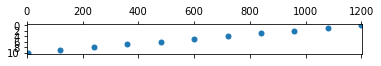

In [4]:
%matplotlib inline
plt.spy(H_obs, marker=".", aspect=10.)
plt.show()

First we run the model for a certain amount of spin-up time beforehand.

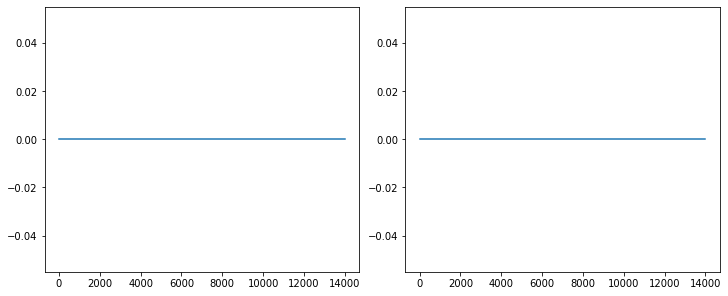

In [5]:
u, h = extract_components(swe_dgp)
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
axs[0].plot(swe_dgp.x_coords, u)
axs[1].plot(swe_dgp.x_coords, h)
plt.show()

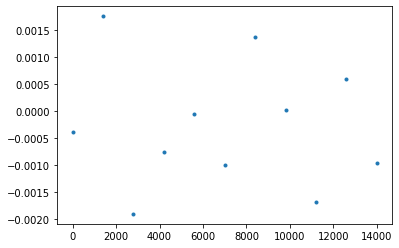

In [6]:
h_true = swe_dgp.du.compute_vertex_values()[(control["nx"] + 1)::nx_skip]
h_obs_operator = H_obs @ (swe_dgp.du.vector().get_local())
np.testing.assert_allclose(h_obs_operator, h_true)

y_obs = swe_dgp.du.compute_vertex_values()[(control["nx"] + 1)::nx_skip]
y_obs += sigma_y * np.random.normal(size=(n_obs, ))

plt.plot(x_obs, y_obs, ".")
plt.show()

In [7]:
norm = np.linalg.norm
errors_u = np.zeros((nt, ))
errors_h = np.zeros((nt, ))

t = 0.
for i in range(nt_warmup):
    t += swe_post.dt
    swe_dgp.solve(t)

In [8]:
swe_post.du_prev.vector().set_local(swe_dgp.du_prev.vector().get_local())

norm = np.linalg.norm
var_norm = np.zeros((nt, ))
errors_u = np.zeros((nt, ))
errors_h = np.zeros((nt, ))

for i in range(nt):
    t += swe_post.dt

    swe_dgp.solve(t)
    swe_post.prediction_step(t)
    if i % nt_skip == 0:
        y_obs = swe_dgp.du.compute_vertex_values()[(control["nx"] + 1)::nx_skip]
        y_obs += sigma_y * np.random.normal(size=(n_obs, ))
        swe_post.update_step(y_obs, H_obs, sigma_y)
        
    swe_post.set_prev()
    
    u_true, h_true = extract_components(swe_dgp)
    u_mean, h_mean = extract_components(swe_post)
    errors_u[i] = norm(u_true - u_mean) / norm(u_true)
    errors_h[i] = norm(h_true - h_mean) / norm(h_true)
    var_norm[i] = norm(swe_post.cov.diagonal())

In [13]:
print(errors_u[-1])
print(errors_h[-1])

0.010440383200219101
0.008874230176162025


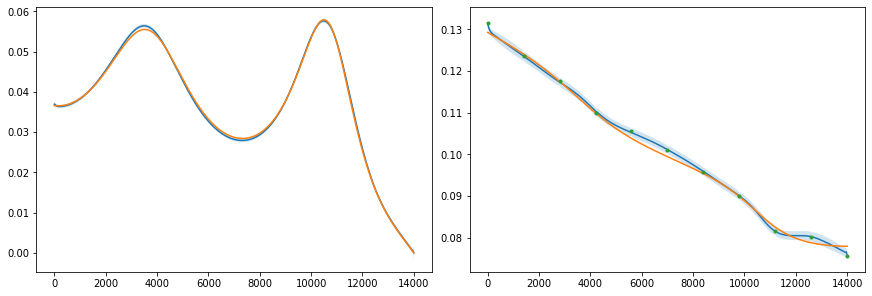

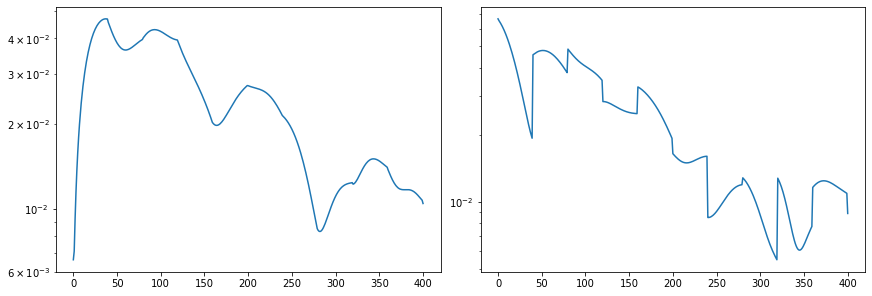

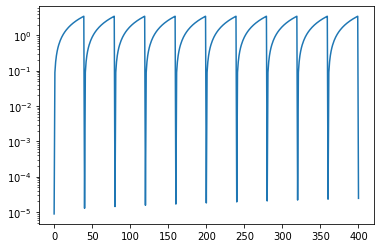

In [9]:
# print(t)        
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

H_u_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=0)
H_h_verts = build_observation_operator(swe_dgp.x_coords, swe_dgp.W, sub=1)
var_u = np.diagonal(H_u_verts @ swe_post.cov @ H_u_verts.T)
var_h = np.diagonal(H_h_verts @ swe_post.cov @ H_h_verts.T)

axs[0].plot(swe_dgp.x_coords, u_mean)
axs[0].fill_between(swe_dgp.x_coords[:, 0], 
                    u_mean - np.sqrt(var_u), u_mean + np.sqrt(var_u),
                    alpha=0.2)
axs[0].plot(swe_dgp.x_coords, u_true)


axs[1].plot(swe_dgp.x_coords, h_mean)
axs[1].fill_between(swe_dgp.x_coords[:, 0], 
                    h_mean - np.sqrt(var_h), h_mean + np.sqrt(var_h),
                    alpha=0.2)
axs[1].plot(swe_dgp.x_coords, h_true)
axs[1].plot(x_obs, y_obs, ".")
plt.show()

fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
axs[0].semilogy(errors_u)
axs[1].semilogy(errors_h)
plt.show()

plt.semilogy(var_norm)
plt.show()

In [10]:
var_norm_pred = np.zeros((nt_pred, ))

for i in range(nt_pred):
    t += swe_post.dt
    swe_dgp.solve(t)
    swe_post.prediction_step(t)
    swe_post.set_prev()
    
    u_true, h_true = extract_components(swe_dgp)
    u_mean, h_mean = extract_components(swe_post)

    var_norm_pred[i] = norm(swe_post.cov.diagonal())

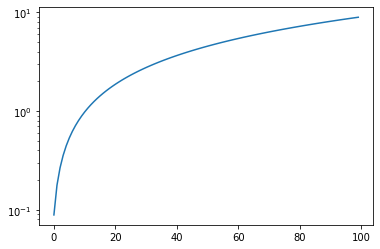

In [11]:
plt.semilogy(var_norm_pred)

In [12]:
# %load_ext line_profiler
# %lprun -f swe_post.prediction_step swe_post.prediction_step(t)